In [6]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()

  Activating environment at `~/SSD/Code/Julia/tinympc-julia/quadrotor_quat/Project.toml`


In [7]:
using LinearAlgebra
using BlockDiagonals
using ForwardDiff
using Plots
using Random; 
using Printf

In [8]:
Pkg.add("Symbolics")

    Updating registry at `~/.julia/registries/General`


    Updating git-repo `https://github.com/JuliaRegistries/General`


   Resolving package versions...


  No Changes to `~/SSD/Code/Julia/tinympc-julia/quadrotor_quat/Project.toml`
  No Changes to `~/SSD/Code/Julia/tinympc-julia/quadrotor_quat/Manifest.toml`


In [9]:
#Quaternion stuff
function hat(v)
    return [0 -v[3] v[2];
            v[3] 0 -v[1];
            -v[2] v[1] 0]
end
function L(q)
    s = q[1]
    v = q[2:4]
    L = [s    -v';
         v  s*I+hat(v)]
    return L
end
T = Diagonal([1; -ones(3)])
H = [zeros(1,3); I]
function qtoQ(q)
    return H'*T*L(q)*T*L(q)*H
end
function G(q)
    G = L(q)*H
end
function rptoq(ϕ)
    (1/sqrt(1+ϕ'*ϕ))*[1; ϕ]
end
function qtorp(q)
    q[2:4]/q[1]
end
function E(q)
    E = BlockDiagonal([1.0*I(3), G(q), 1.0*I(6)])
end

E (generic function with 1 method)

In [10]:
#Quadrotor parameters
m = 0.03
ℓ = 0.046
J = [16.6e-6 0.83e-6 0.72e-6;
    0.83e-6 16.6e-6 1.8e-6;
    0.72e-6 1.8e-6 29.3e-6];
g = 9.81
thrustToTorque = 0.005964552
ℓ = 0.046/sqrt(2)
scale = 65535
kt = 2.245365e-7*scale*g # u is PWM in range [0...1]
km = kt*thrustToTorque #4.4733e-8


h = 1/100 #50 Hz

Nx = 13     # number of states (quaternion)
Nx̃ = 12     # number of states (linearized)
Nu = 4     # number of controls
nx = Nx̃
nu = Nu
Tfinal = 5.0 # final time
Nt = Int(Tfinal/h)+1    # number of time steps
t_vec = h*(0:Nt-1)
thist = Array(range(0,h*(Nt-1), step=h));

In [11]:
function quad_dynamics(x,u)
  r = x[1:3]
  q = x[4:7]/norm(x[4:7]) #normalize q just to be careful
  v = x[8:10]
  ω = x[11:13]
  Q = qtoQ(q)
  
  ṙ = Q*v
  q̇ = 0.5*L(q)*H*ω
  
  v̇ = Q'*[0; 0; -g] + (1/m)*[zeros(2,4); kt*ones(1,4)]*u - hat(ω)*v
  
  ω̇ = J\(-hat(ω)*J*ω + [-ℓ*kt -ℓ*kt ℓ*kt ℓ*kt; -ℓ*kt ℓ*kt ℓ*kt -ℓ*kt; -km km -km km]*u)
  
  return [ṙ; q̇; v̇; ω̇]
end
function quad_dynamics_rk4(x,u)
  #RK4 integration with zero-order hold on u
  f1 = quad_dynamics(x, u)
  f2 = quad_dynamics(x + 0.5*h*f1, u)
  f3 = quad_dynamics(x + 0.5*h*f2, u)
  f4 = quad_dynamics(x + h*f3, u)
  xn = x + (h/6.0)*(f1 + 2*f2 + 2*f3 + f4)
  xn[4:7] .= xn[4:7]/norm(xn[4:7]) #re-normalize quaternion
  return xn
end

quad_dynamics_rk4 (generic function with 1 method)

In [12]:
#Goal state
uhover = (0.5)*ones(4)  # m = 30g and max thrust = 60g
rg = [0.0; 0; 1.0]
qg = [1.0; 0; 0; 0]
vg = zeros(3)
ωg = zeros(3)
xg = [rg; qg; vg; ωg];

In [13]:
#Linearize dynamics about hover
A = ForwardDiff.jacobian(x->quad_dynamics_rk4(x,uhover),xg)
B = ForwardDiff.jacobian(u->quad_dynamics_rk4(xg,u),uhover);
Ã = Array(E(qg)'*A*E(qg))
B̃ = Array(E(qg)'*B);
function discrete_dynamics(params,x,u,k)
  Ã*x + B̃*u
end

discrete_dynamics (generic function with 1 method)

In [14]:
#LQR Controller
# K = dlqr(Ã,B̃,Q,R)
#Feedback controller
function controller_lqr(x, k)
    
  q0 = x0[4:7]
  q = x[4:7]
  ϕ = qtorp(L(q0)'*q)
  
  Δx̃ = [x[1:3]-r0; ϕ; x[8:10]-v0; x[11:13]-ω0]
  
  u = uhover - K*Δx̃
end

controller_lqr (generic function with 1 method)

ΔJ = 0.05807735842324746
ΔJ = 0.0017230679093245271


ΔJ = 0.0
iter     J           ΔJ        |d|         α        reg         ρ
---------------------------------------------------------------------
  1    9.872e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+00


convio = 0.8927130531579544
ΔJ = 

0.6490663986264735


ΔJ = 0.0
  2    9.888e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+01
convio = 0.6277364174662154
ΔJ = 

8.535328844499873


ΔJ = 0.023236233700117737
ΔJ = 

0.0
  3    9.931e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+02
convio = 0.1989624706038451


ΔJ = 12.365214245598168
ΔJ = 0.04551384671060532


ΔJ = 0.0
  4    9.950e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+03
convio = 0.02556931438140375
ΔJ = 

2.2508173074778597


ΔJ = 0.0
  5    9.952e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+04
convio = 0.0026352571158057003
ΔJ = 

0.25701067465740834


ΔJ = 0.0
  6    9.953e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+05
convio = 0.00026433752166288293
ΔJ = 

0.026703825435561157


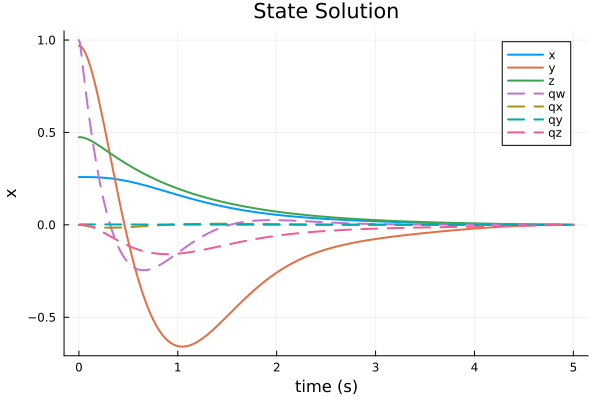

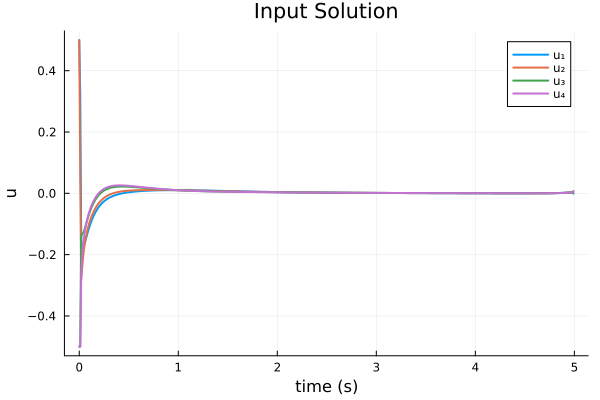

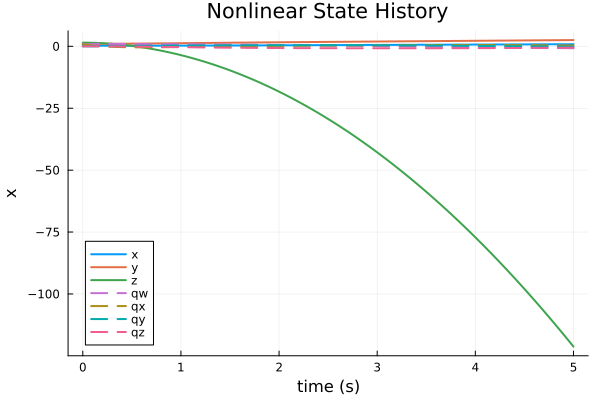

ΔJ = 0.0
  7    9.953e+02   0.00e+00   0.00e+00  1.0000    1.00e-08    1.00e+06
convio = 2.644194165180025e-5


In [15]:
# #Feedback hovering controller
# include("tinyMPC.jl")
# nx = Nx̃
# nu = Nu
# N = Nt
# dt = h

# Q = I(nx)
# R = I(nu)

# Δx̃g = zeros(nx)
# Xref = [deepcopy(Δx̃g) for i = 1:N]
# Uref = [zeros(nu) for i = 1:N-1]

# u_min = -1*uhover
# u_max =  1*uhover

# x_min = -100.0*ones(nx)
# x_min[1:7] .= -.8
# x_max = 100.0*ones(nx)
# x_max[1:7] .= 1.0

# max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
# ncx = 2*nx*0
# ncu = 2*nu*1
# ncg = 1
# ncu_cone = nu*0; 
# cone_scale = 1e-3  # very fragile for each problem

# μ = [zeros(ncu) for i = 1:N-1]   # input constraints
# μx = [zeros(ncx) for i = 1:N]    # state constraints
# λ = zeros(nx)    # goal constraint
# λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
# A_cone = [1 0 0; 0 1 0]
# c_cone = [0.0, 0.0, tand(0)]

# params = (
#     nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
#     μ = μ, μx = μx, λ = λ, λc = λc,
#     A_cone = A_cone, c_cone = c_cone,
#     N = N, Q = Q, R = R, Qf = 10*Q,
#     u_min = u_min, u_max = u_max,
#     x_min = x_min, x_max = x_max,
#     Xref = Xref, Uref = Uref, dt = dt,
# );

# # previous MPC iterate
# X = [zeros(nx) for i = 1:N]
# U = [ones(nu) for k = 1:N-1]
# # new MPC iterate
# Xn = deepcopy(X)
# Un = deepcopy(U)

# P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
# p = [zeros(nx) for i = 1:N]      # cost to go linear term
# d = [zeros(nu) for i = 1:N-1]    # feedforward control
# K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

# Random.seed!(12);
# x = [rg+rand(3); L(qg)*rptoq([1; 0; 0]); vg; ωg];
# q = x[4:7]
# ϕ = qtorp(L(qg)'*q)    
# Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
# X[1] .= Δx̃
# u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=true,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# # Open-loop Simulation
# xhist = zeros(Nx,N)
# xhist[:,1] = x
# for k = 1:(N-1)
#     xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
# end

# # Plots
# Xsim_m = mat_from_vec(Xn)
# Usim_m = mat_from_vec(Un)
# display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
# linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
#              title="State Solution", xlabel="time (s)", ylabel="x"))
# display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
#              title="Input Solution", linewidth=[2 2 2 2 2 2 2],
#              xlabel="time (s)", ylabel="u"))
# display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
# linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
#              title="Nonlinear State History", xlabel="time (s)", ylabel="x"))             

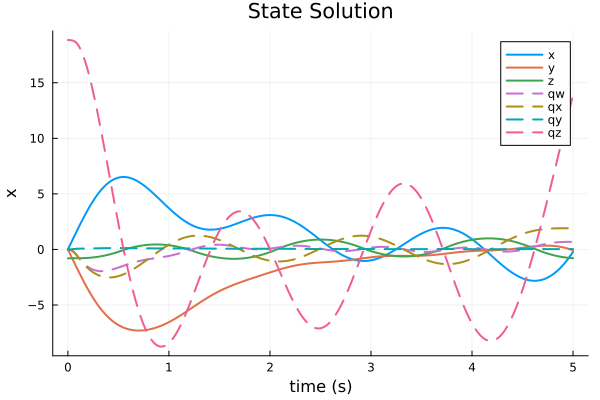

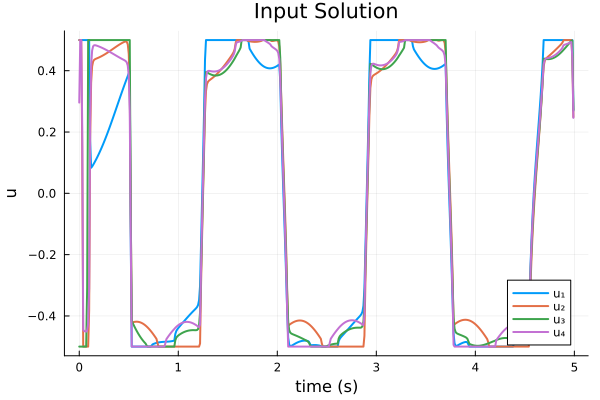

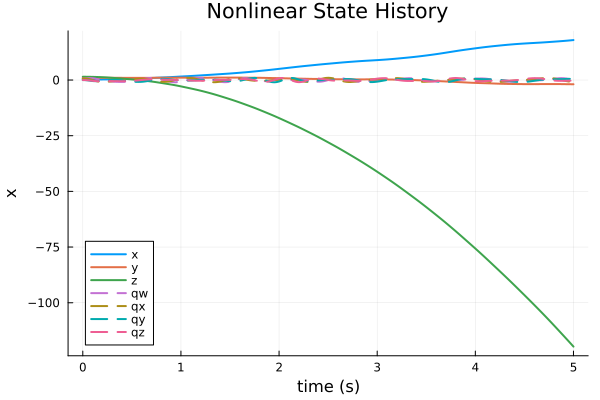

In [16]:
# #Feedback tracking controller
# include("tinyMPC.jl")
# nx = Nx̃
# nu = Nu
# N = Nt
# dt = h

# # Δx̃g = zeros(nx)
# # Xref = [deepcopy(Δx̃g) for i = 1:N]
# Δx̃ref = [zeros(nx) for i = 1:Nt]
# Uref = [zeros(nu) for i = 1:Nt-1]
# Xref = [[5*cos(t);5*cos(t)*sin(t);1.2+sin(t);1;zeros(9)] for t = range(-pi/2, 3*pi/2 + 4*pi, length = Nt)]
# for i = 1:Nt-1
#     Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
# end
# for k = 1:Nt
#     rref = Xref[k][1:3]
#     qref = Xref[k][4:7]
#     vref = Xref[k][8:10]
#     ωref = Xref[k][11:13]
#     ϕ = qtorp(L(qg)'*qref)    
#     Δx̃ref[k] .= [-xg[1:3]+rref; ϕ; -xg[8:10]+vref; -xg[11:13]+ωref]
# end
# u_min = -uhover
# u_max =  uhover

# # state is x y v θ
# x_min = -ones(nx)
# x_max = ones(nx)

# max_inner_iters = 10  # MAX RICCATI SOLVING ITERATION
# ncx = 2*nx*0
# ncu = 2*nu*1
# ncg = 0
# ncu_cone = nu*0; 
# cone_scale = 1e-3  # very fragile for each problem

# μ = [zeros(ncu) for i = 1:N-1]   # input constraints
# μx = [zeros(ncx) for i = 1:N]    # state constraints
# λ = zeros(nx)    # goal constraint
# λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
# A_cone = [1 0 0; 0 1 0]
# c_cone = [0.0, 0.0, tand(0)]

# params = (
#     nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
#     μ = μ, μx = μx, λ = λ, λc = λc,
#     A_cone = A_cone, c_cone = c_cone,
#     N = N, Q = 10*Q, R = R, Qf = 10*Q,
#     u_min = u_min, u_max = u_max,
#     x_min = x_min, x_max = x_max,
#     Xref = Δx̃ref, Uref = Uref, dt = dt,
# );

# # previous MPC iterate
# X = [zeros(nx) for i = 1:N]
# U = [zeros(nu) for k = 1:N-1]
# # new MPC iterate
# Xn = deepcopy(X)
# Un = deepcopy(U)

# P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
# p = [zeros(nx) for i = 1:N]      # cost to go linear term
# d = [zeros(nu) for i = 1:N-1]    # feedforward control
# K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

# X[1] .= Δx̃ref[1]
# u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-4,max_iters=20,verbose=false,ρ=1e0,ρ_max=1e10, ϕ=10.0)

# # Open-loop Simulation
# xhist = zeros(Nx,N)
# xhist[:,1] = x
# for k = 1:(N-1)
#     xhist[:,k+1] = quad_dynamics_rk4(xhist[:,k],Un[k])
# end

# # Plots
# Xsim_m = mat_from_vec(Xn)
# Usim_m = mat_from_vec(Un)
# display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
# linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
#              title="State Solution", xlabel="time (s)", ylabel="x"))
# display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
#              title="Input Solution", linewidth=[2 2 2 2 2 2 2],
#              xlabel="time (s)", ylabel="u"))
# display(plot(t_vec,xhist[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
# linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
#              title="Nonlinear State History", xlabel="time (s)", ylabel="x"))   

In [17]:
# #Feedback tracking controller
# include("tinyMPC.jl")
# nx = Nx̃
# nu = Nu
# N = 10
# dt = h
# Tfinal = 10.0 # final time
# Nt = Int(Tfinal/h)+1    # number of time steps
# t_vec = h*(0:Nt-1)

# #Create trajectory to follow
# Xref = [[0;0;1;1;zeros(9)] for i = 1:Nt+N]
# Δx̃ref = [zeros(nx) for i = 1:Nt+N]
# Uref = [zeros(nu) for i = 1:Nt+N-1]

# # Number-eight
# Xref = [[1*cos(t)*sin(t);1*cos(t);1;1;zeros(9)] for t = range(0, 2*pi + 1*pi/4, length = Nt+N)]  

# # Triangle
# # p0 = [0; 0; 1.0]; p1 = [2; 3; 2.]; p2 = [0; 6; 2.]; p3 = [0; -2; 1.0]
# # range1 = collect(LinRange(p0, p1, round(Int,(Nt+N)/3)))
# # range2 = collect(LinRange(p1, p2, round(Int,(Nt+N)/3)))
# # range3 = collect(LinRange(p2, p3, round(Int,(Nt+N)/3)+1))
# # range123 = [range1; range2; range3]
# # for k = 1:Nt+N
# #     Xref[k][1:3] .= range123[k]
# # end

# for i = 1:Nt+N-1
#     Xref[i][8:10] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
# end
# for k = 1:Nt+N
#     x = Xref[k]
#     q = x[4:7]
#     ϕ = qtorp(L(qg)'*q)   
#     Δx̃ref[k] .= [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
# end

# u_min = -1*uhover
# u_max =  1*uhover

# # state is x y v θ
# x_min = -100*ones(nx)
# x_min[3] = -0.3
# x_max = 100*ones(nx)
# x_max[3] = 0.3

# ncx = 2*nx*0
# ncu = 2*nu*0
# ncg = 0
# ncu_cone = nu*0; 
# cone_scale = 1e-3  # very fragile for each problem

# μ = [zeros(ncu) for i = 1:N-1]   # input constraints
# μx = [zeros(ncx) for i = 1:N]    # state constraints
# λ = zeros(nx)    # goal constraint
# λc = [zeros(ncu_cone) for i = 1:N-1]   # goal constraint
# A_cone = [1 0 0; 0 1 0]
# c_cone = [0.0, 0.0, tand(0)]

# params = (
#     nx = nx, nu = nu, ncx = ncx, ncu = ncu, ncg = ncg, ncu_cone = ncu_cone,
#     μ = μ, μx = μx, λ = λ, λc = λc,
#     A_cone = A_cone, c_cone = c_cone,
#     N = N, Q = 10*Q, R = R, Qf = 10*Q,
#     u_min = u_min, u_max = u_max,
#     x_min = x_min, x_max = x_max,
#     Xref = Δx̃ref, Uref = Uref, dt = dt,
# );
    
# # previous MPC iterate
# X = [zeros(nx) for i = 1:N]
# U = [zeros(nu) for k = 1:N-1]
# # new MPC iterate
# Xn = deepcopy(X)
# Un = deepcopy(U)
    
# P = [zeros(nx,nx) for i = 1:N]   # cost to go quadratic term
# p = [zeros(nx) for i = 1:N]      # cost to go linear term
# d = [zeros(nu) for i = 1:N-1]    # feedforward control
# K = [zeros(nu,nx) for i = 1:N-1] # feedback gain

# function controller_mpc(params, x, k)
#     q = x[4:7]
#     ϕ = qtorp(L(qg)'*q)
    
#     Δx̃ = [x[1:3]-rg; ϕ; x[8:10]-vg; x[11:13]-ωg]
#     X[1] .= Δx̃
#     # u = mpc_JuMP(optimizer, params, X, U, Ã, B̃, 0.0; warm_start=true)
#     u = mpc!(params,X,U,P,p,K,d,Xn,Un; atol=1e-2,max_iters=20,max_inner_iters=5,verbose=false,ρ=1e0,ρ_max=1e6, ϕ=10.0)
#     return u + uhover
# end

In [18]:
#Simulation
uhist = [zeros(Nu) for i in 1:Nt-1]
xhist = [zeros(Nx) for i in 1:Nt]
Random.seed!(12);
# xhist[1] .= [rg+randn(3); L(qg)*rptoq([1; 0; 0]); vg; ωg]  # initial conditions
xhist[1] .= Xref[1]
# xhist[1] .= Xref[1]; xhist[1][1:3] += rand(3)*0.2
for k = 1:(Nt-1)
    params1 = (; params..., Uref = Uref[k:N+k-1], Xref = Δx̃ref[k:N+k])  # update ref
    shift_fill(U)
    @time uhist[k] = controller_mpc(params1, xhist[k], k)
    uhist[k] = clamp.(uhist[k], (uhover+u_min)[1], (uhover+u_max)[1])
    xhist[k+1] = quad_dynamics_rk4(xhist[k],uhist[k]) 
end

BoundsError: BoundsError: attempt to access 500-element Vector{Vector{Float64}} at index [1:501]

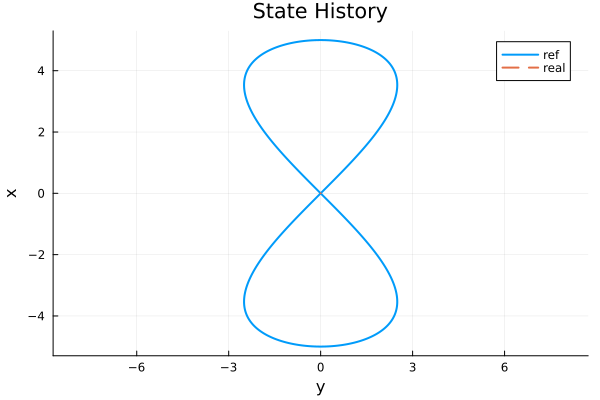

In [19]:
Xsim_m = mat_from_vec(Xref[1:Nt])
plot(Xsim_m[2,:],Xsim_m[1,:],label="ref",
linestyle=:solid, linewidth=2,
             title="State History", xlabel="y", ylabel="x")
Xsim_m = mat_from_vec(xhist[1:Nt])   
display(plot!(Xsim_m[2,:],Xsim_m[1,:],label="real", linestyle=:dash, linewidth=2,
             title="State History", xlabel="y", ylabel="x", aspect_ratio=:equal))

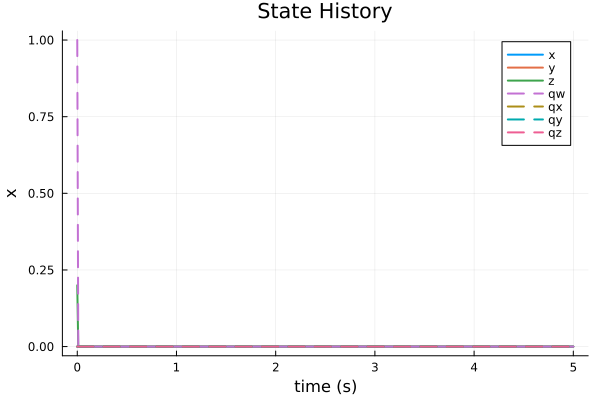

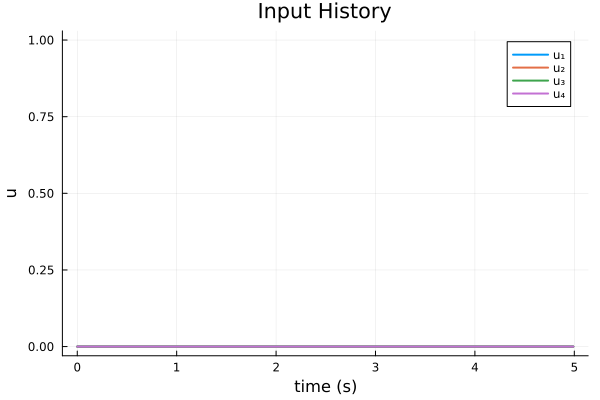

In [20]:
Xsim_m = mat_from_vec(xhist[1:Nt])   
Usim_m = mat_from_vec(uhist[1:Nt-1])   
display(plot(t_vec,Xsim_m[1:7,:]',label=["x" "y" "z" "qw" "qx" "qy" "qz"],
linestyle=[:solid :solid :solid :dash :dash :dash :dash], linewidth=[2 2 2 2 2 2 2],
             title="State History", xlabel="time (s)", ylabel="x"))
display(plot(t_vec[1:end-1],Usim_m',label=["u₁" "u₂" "u₃" "u₄"],
             title="Input History", linewidth=[2 2 2 2 2 2 2],
             xlabel="time (s)", ylabel="u"))

In [21]:
display(Ã)

@printf("FOR C:\n");
str = "sfloat A_data[NSTATES*NSTATES] = {\n"
ÃT = Ã'
for i = 1:Nx̃
  str = str * "  "
  for j = 1:Nx̃
    this_str = @sprintf("%.6f", ÃT[i, j])
    str = str * this_str * "f,"
  end
  str = str * "\n"
end
str = str * "};"
@printf("%s",str)

@printf("\n\nFOR PYTHON:\n");
# Python Language
str = "A = np.array([\n"
for i = 1:Nx̃
  str = str * "  ["
  for j = 1:Nx̃
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", Ã[i, j])

    str = str * this_str 
    if j < Nx̃
      str = str * ","
    end
  end
  str = str * "],\n"
end
str = str * "])"
@printf("%s",str)

12×12 Matrix{Float64}:
 1.0  0.0  0.0   0.0          0.000962361  …   0.0         1.60393e-6  0.0
 0.0  1.0  0.0  -0.000962361  0.0             -1.60393e-6  0.0         0.0
 0.0  0.0  1.0   0.0          0.0              0.0         0.0         0.0
 0.0  0.0  0.0   1.0          0.0              0.005       0.0         0.0
 0.0  0.0  0.0   0.0          1.0              0.0         0.005       0.0
 0.0  0.0  0.0   0.0          0.0          …   0.0         0.0         0.005
 0.0  0.0  0.0   0.0          0.1962           0.0         0.00049982  0.0
 0.0  0.0  0.0  -0.1962       0.0             -0.00049982  0.0         0.0
 0.0  0.0  0.0   0.0          0.0              0.0         0.0         0.0
 0.0  0.0  0.0   0.0          0.0              1.0         0.0         0.0
 0.0  0.0  0.0   0.0          0.0          …   0.0         1.0         0.0
 0.0  0.0  0.0   0.0          0.0              0.0         0.0         1.0

FOR C:
sfloat A_data[NSTATES*NSTATES] = {
  1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,-0.000962f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,-0.196200f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000962f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.196200f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.010000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,
  0.000000f,0.010000f,0.000000f,0.000000f,0.000000f,0.000000f,0.000000f,1.000000f,0.000000f,0.0



FOR PYTHON:
A = np.array([
  [1.000000,0.000000,0.000000,0.000000,0.000962,0.000000,0.010000,0.000000,0.000000,0.000000,0.000002,0.000000],
  [0.000000,1.000000,0.000000,-0.000962,0.000000,0.000000,0.000000,0.010000,0.000000,-0.000002,0.000000,0.000000],
  [0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000],
  [0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.000000,0.000000],
  [0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000,0.000000],
  [0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005000],
  [0.000000,0.000000,0.000000,0.000000,0.196200,0.000000,1.000000,0.000000,0.000000,0.000000,0.000500,0.000000],
  [0.000000,0.000000,0.000000,-0.196200,0.000000,0.000000,0.000000,1.000000,0.000000,-0.000500,0.000000,0.000000],
  [0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

In [22]:
display(B̃)

@printf("FOR C:\n");
str = "sfloat B_data[NSTATES*NINPUTS] = {\n"
B̃T = B̃'
for i = 1:Nu
  str = str * "  "
  for j = 1:Nx̃
    this_str = @sprintf("%.6f", B̃T[i, j])
    str = str * this_str * "f,"
  end
  str = str * "\n"
end
str = str * "};"
@printf("%s",str)

@printf("\n\nFOR PYTHON:\n");
# Python Language
str = "B = np.array([\n"
for i = 1:Nx̃
  str = str * "  ["
  for j = 1:Nu
    # if abs(K[i, j]) < 1e-6
    #   K[i, j] = 0.0
    # end
    this_str = @sprintf("%.6f", B̃[i, j])

    str = str * this_str 
    if j < Nu
      str = str * ","
    end
  end
  str = str * "],\n"
end
str = str * "])"
@printf("%s",str)

12×4 Matrix{Float64}:
 -1.07752e-6    1.18597e-6    1.10281e-6   -1.21127e-6
  1.07924e-6    1.19673e-6   -1.08827e-6   -1.18769e-6
  0.00024059    0.00024059    0.00024059    0.00024059
 -0.00672869   -0.0074612     0.00678501    0.00740488
 -0.00671796    0.00739415    0.00687567   -0.00755186
 -0.000156594   0.000463747  -0.00132377    0.00101662
 -0.00045605    0.000501953   0.000466756  -0.000512659
  0.000456778   0.000506505  -0.000460602  -0.000502682
  0.048118      0.048118      0.048118      0.048118
 -2.69147      -2.98448       2.714         2.96195
 -2.68719       2.95766       2.75027      -3.02074
 -0.0626376     0.185499     -0.52951       0.406649

FOR C:
sfloat B_data[NSTATES*NINPUTS] = {
  -0.000001f,0.000001f,0.000241f,-0.006729f,-0.006718f,-0.000157f,-0.000456f,0.000457f,0.048118f,-2.691475f,-2.687185f,-0.062638f,
  0.000001f,0.000001f,0.000241f,-0.007461f,0.007394f,0.000464f,0.000502f,0.000507f,0.048118f,-2.984480f,2.957661f,0.185499f,
  0.000001f,-0.000001f,0.000241f,0.006785f,0.006876f,-0.001324f,0.000467f,-0.000461f,0.048118f,2.714004f,2.750267f,-0.529510f,
  -0.000001f,-0.000001f,0.000241f,0.007405f,-0.007552f,0.001017f,-0.000513f,-0.000503f,0.048118f,2.961950f,-3.020743f,0.406649f,
};

FOR PYTHON:
B = np.array([
  [-0.000001,0.000001,0.000001,-0.000001],
  [0.000001,0.000001,-0.000001,-0.000001],
  [0.000241,0.000241,0.000241,0.000241],
  [-0.006729,-0.007461,0.006785,0.007405],
  [-0.006718,0.007394,0.006876,-0.007552],
  [-0.000157,0.000464,-0.001324,0.001017],
  [-0.000456,0.000502,0.000467,-0.000513],
  [0.000457,0.000507,-0.000461,-0.000503],
  [0.048118,0.048118,0.048118,0.048118],
  [-2.691475,-2.984480,2.714004,

In [23]:
using Symbolics
@variables x[1:12] u[1:4] 
x = collect(x); u = collect(u)
# ====================
# Generate C code for dynamics
# ====================
function dynamics_rk4_(x,u)
    discrete_dynamics(params,x,u,0)
end
dynamics_rk4 = dynamics_rk4_(x,u)
dynamics_rk4 = build_function(dynamics_rk4, x, u; target=Symbolics.CTarget(), 
    fname = :tiny_Dynamics_RK4_Raw, lhsname=:xn, rhsnames=[Symbol("x"), Symbol("u")])
open("dynamics_rk4.txt","a") do io
        println(io, dynamics_rk4)
end

In [24]:
# Export a vector of vectors to C header and source 
function export_vec_to_c(filename, var_type, var_name, data)
    declare = var_type * " " * var_name
    def = declare * " = {\n"
    for i=1:length(data)
        def = def * "  "
        for j=1:length(data[1])
            def = def * string(data[i][j])
            if j < length(data[1]) 
                def = def * ","
            end
        end
        if i < length(data)
            def = def * ",\n"
        end
    end
    def = def*"}"

    open(filename*".h","a") do io
            println(io, def * ";\n")
    end
    return true
end
export_vec_to_c("data", "sfloat", "X_ref_data", Δx̃ref)

true

In [25]:
Δx̃ref

501-element Vector{Vector{Float64}}:
 [3.061616997868383e-16, -3.061616997868383e-16, -0.8, 0.0, 0.0, 0.0, 18.845091334967314, -18.831701381983226, 0.07105273594107953, 0.0, 0.0, 0.0]
 [0.18845091334967345, -0.18831701381983257, -0.7992894726405892, 0.0, 0.0, 0.0, 18.818311428999028, -18.724695898206022, 0.21305723799752707, 0.0, 0.0, 0.0]
 [0.37663402763966375, -0.3755639728018928, -0.797158900260614, 0.0, 0.0, 0.0, 18.764789672774533, -18.511292957156076, 0.3547589740605539, 0.0, 0.0, 0.0]
 [0.5642819243674091, -0.5606769023734536, -0.7936113105200084, 0.0, 0.0, 0.0, 18.684602123637628, -18.19270515691338, 0.4959565782094333, 0.0, 0.0, 0.0]
 [0.7511279456037854, -0.7426039539425874, -0.7886517447379141, 0.0, 0.0, 0.0, 18.57786273248383, -17.770742776910797, 0.6364494009225452, 0.0, 0.0, 0.0]
 [0.9369065729286237, -0.9203113817116954, -0.7822872507286887, 0.0, 0.0, 0.0, 18.444723181828216, -17.247803491563683, 0.7760377942111485, 0.0, 0.0, 0.0]
 [1.1213538047469058, -1.092789416627332